In [0]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import glob
from PIL import Image
import time
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# Define some constants
KERNEL_SIZE = 3
PADDING = KERNEL_SIZE//2
BATCH_SIZE = 10

In [0]:
colors = [
   (255, 255, 255),
   (236, 254, 252),
   (196, 254, 252),
   (156, 234, 252),
   (156, 218, 252),
   (180, 198, 252),
   (180, 254, 156),
   (180, 234, 156),
   (164, 218, 156),
   (252, 254, 156),
   (252, 234, 156),
   (252, 218, 156),
   (252, 190, 196),
   (252, 158, 156),
   (228, 158, 164)
]

amount = [
    0,
    1,
    2,
    4,
    8,
    12,
    16,
    24,
    32,
    40,
    48,
    56,
    64,
    80,
    100,
]

# Prepare Dataset and Dataloader

In [0]:
rainy_count = pd.read_csv('rain_count.csv', header=None)
rainy_count.columns = ['date', 'rain']
rainy_count['date'] = pd.to_datetime(rainy_count['date'])
rainy_count.set_index('date', inplace=True)

In [0]:
rain_threshold = 1000

In [0]:
rainy_hours = rainy_count[rainy_count.rain > rain_threshold].index[1:-1]

In [0]:
train_times = rainy_hours[rainy_hours.year < 2017]
valid_times = rainy_hours[rainy_hours.year == 2017]

In [0]:
ts = pd.date_range('2013', '2017', freq='5min')
train_idx = np.empty(len(train_times), dtype=int)
for i,t in enumerate(train_times):
    idx = ts.get_loc(t)
    train_idx[i] = idx

In [0]:
ts = pd.date_range('2017', '2018', freq='5min')
valid_idx = np.empty(len(valid_times), dtype=int)
for i,t in enumerate(valid_times):
    idx = ts.get_loc(t)
    valid_idx[i] = idx

In [0]:
t = train_times[0]-pd.Timedelta('1h')

In [18]:
filename = "{:4d}{:02d}/{:4d}{:02d}{:02d}{:02d}{:02d}.npz".format(t.year,t.month,t.year,t.month,t.day,t.hour,t.minute)
print(filename)
a = np.load(filename)['arr_0']
print(a.shape)

201301/201301021500.npz
(96, 96)


In [0]:
b = np.zeros((24,1,a.shape[0],a.shape[1]))

In [20]:
b.shape

(24, 1, 96, 96)

In [0]:
steps = 24

In [22]:
t1 = train_times[100]
t0 = t1 - steps//2 * pd.Timedelta('5min')
t2 = t1 + steps//2 * pd.Timedelta('5min')
#print(t1)
for i,t in enumerate(pd.date_range(t0, t2, freq='5min')[:-1]):
    filename = "{:4d}{:02d}/{:4d}{:02d}{:02d}{:02d}{:02d}.npz".format(t.year,t.month,t.year,t.month,t.day,t.hour,t.minute)
    print(i, filename)
    img = np.load(filename)['arr_0']
    b[i,0,:,:] = img
    


0 201301/201301262200.npz
1 201301/201301262205.npz
2 201301/201301262210.npz
3 201301/201301262215.npz
4 201301/201301262220.npz
5 201301/201301262225.npz
6 201301/201301262230.npz
7 201301/201301262235.npz
8 201301/201301262240.npz
9 201301/201301262245.npz
10 201301/201301262250.npz
11 201301/201301262255.npz
12 201301/201301262300.npz
13 201301/201301262305.npz
14 201301/201301262310.npz
15 201301/201301262315.npz
16 201301/201301262320.npz
17 201301/201301262325.npz
18 201301/201301262330.npz
19 201301/201301262335.npz
20 201301/201301262340.npz
21 201301/201301262345.npz
22 201301/201301262350.npz
23 201301/201301262355.npz


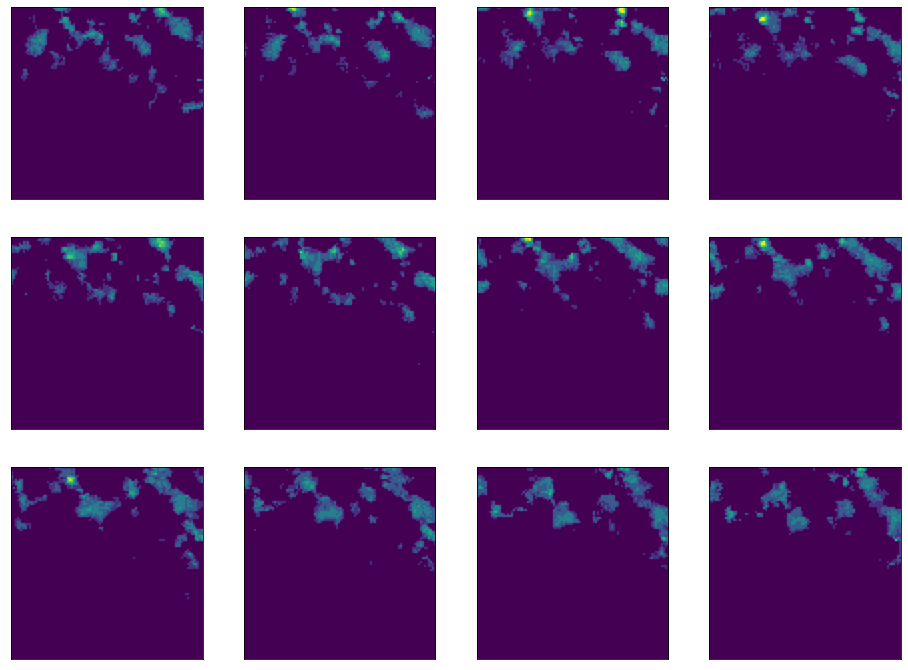

In [23]:
plt.figure(figsize=(16,12))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(b[i,0], vmax=7)
    plt.xticks([])
    plt.yticks([])


In [0]:
class KyotoRadarDataset(Dataset):
    """Kyoto Radar dataset."""

    def __init__(self, times, steps):
        """
        """
        self.times = times
        self.steps = steps
        
    def __len__(self):
        return len(self.times) #- self.steps

    def __getitem__(self, idx):
        out = np.zeros((self.steps,1,96,96), dtype=np.float32)
        t1 = self.times[idx]
        t0 = t1 - self.steps//2 * pd.Timedelta('5min')
        t2 = t1 + self.steps//2 * pd.Timedelta('5min')
        for i,t in enumerate(pd.date_range(t0, t2, freq='5min')[:-1]):
            filename = "{:4d}{:02d}/{:4d}{:02d}{:02d}{:02d}{:02d}.npz".format(t.year,t.month,t.year,t.month,t.day,t.hour,t.minute)
            img = np.load(filename)['arr_0']
            out[i,0,:,:] = img
        out = out / 15.
        return out

2013-01-26 23:00:00


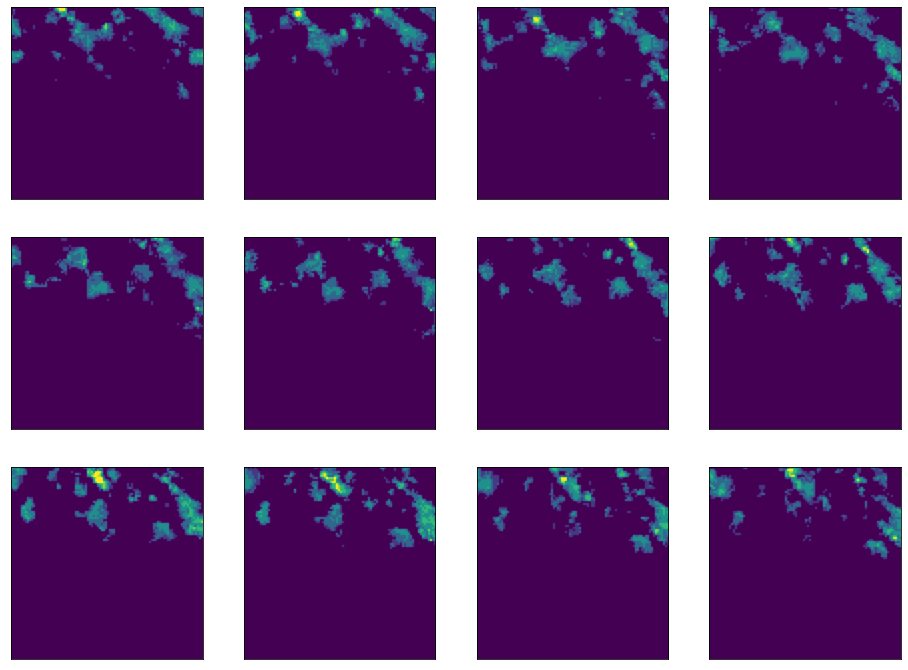

In [25]:
dataset = KyotoRadarDataset(times=train_times, steps=12)
print(train_times[100])
plt.figure(figsize=(16,12))
s = dataset[100]
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(s[i,0], vmax=0.4)
    plt.xticks([])
    plt.yticks([])

In [0]:
radardata_train = KyotoRadarDataset(times=train_times, steps=24)
radardata_valid = KyotoRadarDataset(times=valid_times, steps=24)

train_loader = DataLoader(dataset = radardata_train, batch_size = BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(dataset = radardata_valid, batch_size = BATCH_SIZE, shuffle=False)

In [27]:
#%%time
# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images.shape

torch.Size([10, 24, 1, 96, 96])

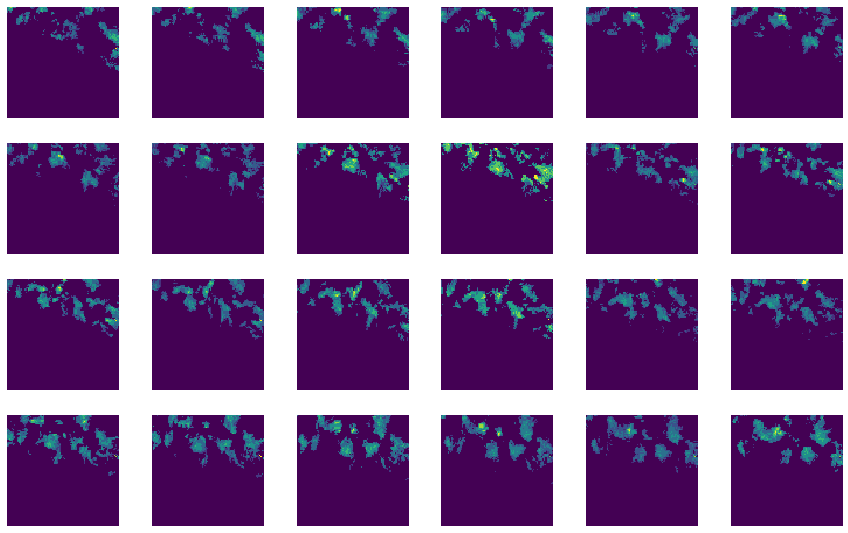

In [28]:
images = dataiter.next()
plt.figure(figsize=(12,8))
bn = 0
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.tight_layout()
    plt.imshow(images[bn,i,0], interpolation='none')
    plt.axis('off')

In [0]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size // 2
        self.bias        = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, (h_next, c_next)

    def reset_parameters(self):
        self.conv.reset_parameters()

    def init_hidden(self, batch_size, width, height):
        return (torch.zeros(batch_size, self.hidden_dim, width, height).cuda(),
                torch.zeros(batch_size, self.hidden_dim, width, height).cuda())


In [0]:
class SatLU(nn.Module):
    def __init__(self, lower=0, upper=15/15, inplace=False):
        super(SatLU, self).__init__()
        self.lower = lower
        self.upper = upper
        self.inplace = inplace

    def forward(self, input):
        return F.hardtanh(input, self.lower, self.upper, self.inplace)

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' ('\
            + 'min_val=' + str(self.lower) \
            + ', max_val=' + str(self.upper) \
            + inplace_str + ')'

In [0]:
class PredNet(nn.Module):
    def __init__(self, R_channels, A_channels):
        super(PredNet, self).__init__()
        self.r_channels = R_channels + (0, )  # for convenience
        self.a_channels = A_channels
        self.n_layers = len(R_channels)

        for i in range(self.n_layers):
            cell = ConvLSTMCell(2 * self.a_channels[i] + self.r_channels[i+1], 
                                self.r_channels[i], KERNEL_SIZE, True)

            setattr(self, 'cell{}'.format(i), cell)

        for i in range(self.n_layers):
            conv = nn.Sequential(nn.Conv2d(self.r_channels[i], self.a_channels[i], KERNEL_SIZE, padding=PADDING), nn.ReLU())
            if i == 0:
                conv.add_module('satlu', SatLU())
            setattr(self, 'conv{}'.format(i), conv)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        for l in range(self.n_layers - 1):
            update_A = nn.Sequential(nn.Conv2d(2* self.a_channels[l], self.a_channels[l+1], KERNEL_SIZE, padding=PADDING), self.maxpool)
            setattr(self, 'update_A{}'.format(l), update_A)

        self.reset_parameters()

    def reset_parameters(self):
        for l in range(self.n_layers):
            cell = getattr(self, 'cell{}'.format(l))
            cell.reset_parameters()


    def forward(self, input, time_steps=1, forecast_steps=0, mode='error'):
        
        R_seq = [None] * self.n_layers
        H_seq = [None] * self.n_layers
        E_seq = [None] * self.n_layers
        
        batch_size, input_steps, channels, width, height = input.size()
        
        w = width
        h = height
        for l in range(self.n_layers):
            E_seq[l] = torch.randn(batch_size, 2*self.a_channels[l], w, h).cuda()
            R_seq[l] = torch.randn(batch_size, self.r_channels[l], w, h).cuda()
            w = w//2
            h = h//2
        
        if mode=='error':
            total_error = []
        else:
            output = []
        
        for t in range(time_steps + forecast_steps):
            if t < input_steps:
                frame_input = input[:,t]
                frame_input = frame_input.type(torch.cuda.FloatTensor)
            else:
                frame_input = None
            
            for l in reversed(range(self.n_layers)):
                cell = getattr(self, 'cell{}'.format(l))
                
                if t == 0:
                    E = E_seq[l]
                    R = R_seq[l]
                    hx = (R, R)
                else:
                    E = E_seq[l]
                    R = R_seq[l]
                    hx = H_seq[l]
                
                if l == self.n_layers - 1:
                    R, hx = cell(E, hx)
                else:
                    tmp = torch.cat((E, F.interpolate(R_seq[l+1], scale_factor=2)), 1)
                    R, hx = cell(tmp, hx)
                
                R_seq[l] = R
                H_seq[l] = hx
                
            for l in range(self.n_layers):
                conv = getattr(self, 'conv{}'.format(l))
                A_hat = conv(R_seq[l])
                
                if l == 0:
                    frame_prediction = A_hat
                    if t < time_steps:
                        A = frame_input
                    else:
                        A = frame_prediction
                
                pos = F.relu(A_hat - A)
                neg = F.relu(A - A_hat)
                E = torch.cat([pos, neg],1)
                E_seq[l] = E
                
                if l < self.n_layers - 1:
                    update_A = getattr(self, 'update_A{}'.format(l))
                    A = update_A(E)
                
            if mode == 'error':
                error = torch.mean((frame_input - frame_prediction)**2)
                total_error.append(error)
            else:
                output.append(frame_prediction)
            
        if mode == 'error':
            return torch.stack(total_error, 0)
        else:
            return torch.stack(output, 1)
        

In [32]:
A_channels = (1, 16, 32, 64)
#A_channels = (1, 32, 64, 128)
R_channels = (1, 16, 32, 64)
#R_channels = (1, 32, 64, 128)

model = PredNet(R_channels, A_channels)
if torch.cuda.is_available():
    print('Using GPU.')
    model.cuda()

Using GPU.


In [39]:
checkpoint = torch.load('/content/gdrive/My Drive/Nowcasting/KyotoRadar/prednet-v4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [40]:
print(model)

PredNet(
  (cell0): ConvLSTMCell(
    (conv): Conv2d(19, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cell1): ConvLSTMCell(
    (conv): Conv2d(80, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cell2): ConvLSTMCell(
    (conv): Conv2d(160, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cell3): ConvLSTMCell(
    (conv): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv0): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (satlu): SatLU (min_val=0, max_val=1.0)
  )
  (conv1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2

In [41]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

768890


In [42]:
e = model(images, time_steps=10, mode='error')
print(e)

tensor([0.0043, 0.0011, 0.0009, 0.0007, 0.0007, 0.0006, 0.0007, 0.0006, 0.0007,
        0.0007], device='cuda:0', grad_fn=<StackBackward>)


In [43]:
o = model(images, time_steps=10, forecast_steps=5, mode='forecast')
print(o.shape)

torch.Size([10, 15, 1, 96, 96])


In [0]:
train_losses = []
train_counter = []
valid_losses = []

In [0]:
def train(epoch, log_interval):
    """Training"""
    model.train()
    loss_log = 0
    for batch_idx, frames in enumerate(train_loader):
        errors = model(frames, time_steps=12, forecast_steps=12, mode='error')
        loss = torch.mean(errors)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_log += loss.item()

        if ((batch_idx + 1) % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx +1) * len(frames), len(train_loader)*BATCH_SIZE,
                100. * (batch_idx +1) / len(train_loader), loss_log / log_interval))
            loss_log = 0
            train_losses.append(loss.item())
            train_counter.append((batch_idx*BATCH_SIZE) + ((epoch-1)*len(train_loader)*BATCH_SIZE))
            #print(' > Epoch {:2d} loss: {:.3f}'.format((epoch + 1), loss.data))
        

In [0]:
def valid():
    """Validation"""
    model.eval()
    loss_log = 0
    with torch.no_grad():
        for batch_idx, frames in enumerate(valid_loader):
            errors = model(frames, time_steps=12, forecast_steps=12, mode='error')
            loss = torch.mean(errors)

            loss_log += loss.item()
        
        loss_log /= len(valid_loader)
        valid_losses.append(loss_log)
        print('\nValidation loss: {:.6f}\n'.format(loss_log))
        

In [46]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/(1024**2), torch.cuda.max_memory_allocated()/(1024**2))

1928.74072265625 1987.10009765625


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
#checkpoint = torch.load('/content/gdrive/My Drive/Nowcasting/KyotoRadar/prednet-out.pth')
#model.load_state_dict(checkpoint['model_state_dict'])

In [53]:
%%time

log_interval = 10
n_epochs = 4

for epoch in range(1, n_epochs + 1):
    train(epoch, log_interval)
    valid()
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, '/content/gdrive/My Drive/Nowcasting/KyotoRadar/prednet-out.pth')

Train Epoch: 1 [100/7590 (1%)]	Loss: 0.001602
Train Epoch: 1 [200/7590 (3%)]	Loss: 0.001609
Train Epoch: 1 [300/7590 (4%)]	Loss: 0.001706
Train Epoch: 1 [400/7590 (5%)]	Loss: 0.002005
Train Epoch: 1 [500/7590 (7%)]	Loss: 0.002489
Train Epoch: 1 [600/7590 (8%)]	Loss: 0.001963
Train Epoch: 1 [700/7590 (9%)]	Loss: 0.001549
Train Epoch: 1 [800/7590 (11%)]	Loss: 0.003576


KeyboardInterrupt: ignored

In [0]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, '/content/gdrive/My Drive/Nowcasting/KyotoRadar/prednet-out.pth')

In [55]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/(1024**2), torch.cuda.max_memory_allocated()/(1024**2))

3801.439453125 5722.3876953125


In [267]:
checkpoint = torch.load('/content/gdrive/My Drive/Nowcasting/KyotoRadar/prednet-All.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [268]:
images.shape

torch.Size([10, 24, 1, 96, 96])

2017-01-09 19:00:00
0.7229380011558533


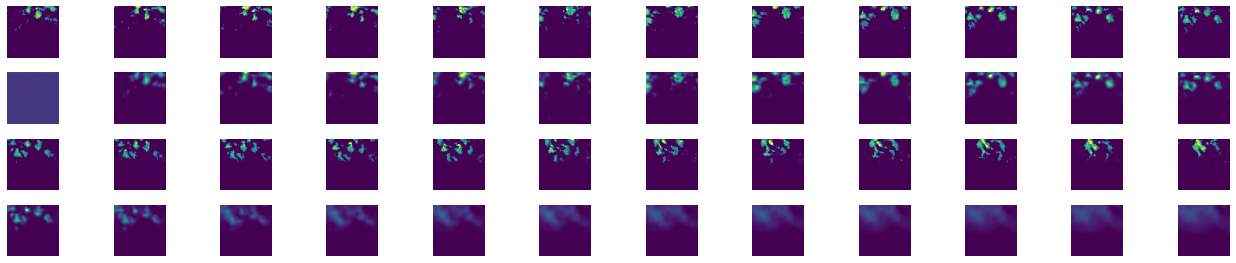

In [269]:
model.eval()
with torch.no_grad():
    idx = 26 #894 
    print(valid_times[idx])
    input_sequence = torch.from_numpy(radardata_valid[idx]).unsqueeze(0)
    #input_sequence = images.cuda()
    
    plt.figure(figsize=(18,4))
    b = 0
    for i in range(12):
        plt.subplot(4,12,i+1)
        plt.tight_layout()
        plt.imshow(input_sequence[0,i,0].cpu().detach().numpy(), vmin=0, vmax=5/15)
        #plt.imshow(input_sequence[b,i,0].cpu().detach().numpy())
        plt.axis('off')
        
        plt.subplot(4,12,i+25)
        plt.tight_layout()
        plt.imshow(input_sequence[0,i+12,0].cpu().detach().numpy(), vmin=0, vmax=5/15)
        #plt.imshow(input_sequence[b,i+12,0].cpu().detach().numpy())
        plt.axis('off')

    output_sequence = model(input_sequence[:,:12,...], time_steps=12, forecast_steps=12, mode='forecast')

    for i in range(12):
        plt.subplot(4,12,i+13)
        plt.tight_layout()
        plt.imshow(output_sequence[b,i,0].cpu().detach().numpy(), vmin=0, vmax=5/15)
        plt.axis('off')

        plt.subplot(4,12,i+37)
        plt.tight_layout()
        plt.imshow(output_sequence[b,i+12,0].cpu().detach().numpy(), vmin=0, vmax=5/15)
        plt.axis('off')
    
    rmse = np.sqrt(((input_sequence[0,12:,0]*15 - output_sequence[0,12:,0].cpu().detach()*15)**2).mean())
    print(rmse.item())
    

In [0]:
def class2rainrate(rr):
    amount = [0,1,2,4,8,12,16,24,32,40,48,56,64,80,100]
    rt=rr.copy().astype(float)
    for i,r in enumerate(amount):
        rt[rr==i]=amount[i]
    return rt